# MULTITASK LEARNING USING MULTILAYER BIDIRECTIONAL LSTM MODEL

## 1. Import statements

**Import necessary packages and modules**

In [1]:
import os
import time
import random
import math
import json
import pandas as pd
import numpy as np
import tensorflow as tf
import progressbar
tf.reset_default_graph()
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**Import gensim**

In [2]:
from gensim.models.word2vec import Word2VecKeyedVectors

**Set the random seed of numpy and tensorflow**

In [3]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 95
tf_rand_seed = 63
np.random.seed(np_rand_seed)
tf.set_random_seed(tf_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  95
tensorflow random seed:  63


## 2. Load train data, test data, and gensim word2vec model

**Set some directories**

In [4]:
input_dir = "../input/"
word2vec_dir = "./word2vec_models/"
model_dir = "./model_files/"
submission_dir = "./submission_dir/"

**Load the cleaned train and test data**

In [5]:
data = pd.read_csv(input_dir+'modified_train_data.csv') 
data = data.sample(frac=1,  random_state = np.random.seed()).reset_index(drop=True)
test_data = pd.read_csv(input_dir+'modified_test_data.csv')

**Extract test ids**

In [6]:
test_ids = test_data.id.values

**Load metadata of word2vec model**

In [7]:
metadata= json.loads(open(word2vec_dir+"data.json").read())
size = metadata['size']

**Load the gensim word2vec model**

In [8]:
fname = "word2vec_model.mdl"
model = Word2VecKeyedVectors.load_word2vec_format(word2vec_dir+fname)

## 3. Undersample clean comments

In [9]:
query_clean = 'toxic==0 and severe_toxic==0 and obscene==0 and threat==0 and insult==0 and identity_hate==0'
print("Number of training points before undersampling:", data.shape[0])
print("Number of clean data before undersampling:",data.query(query_clean).shape[0])

Number of training points before undersampling: 159571
Number of clean data before undersampling: 143346


**Bar chart of representation of toxic comments along with clean comments before undersampling**

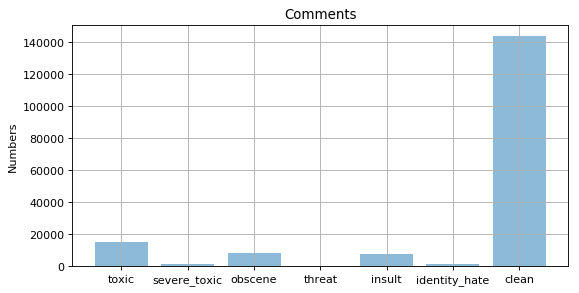

In [10]:
numbers = [data.query('toxic==1').shape[0], data.query('severe_toxic==1').shape[0],
           data.query('obscene==1').shape[0], data.query('threat==1').shape[0],
           data.query('insult==1').shape[0], data.query('identity_hate==1').shape[0],
           data.query(query_clean).shape[0]]

plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(np.arange(len(numbers)), numbers, align='center', alpha=0.5)
plt.xticks(np.arange(len(numbers)),\
           ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean'])
plt.ylabel('Numbers')
plt.title('Comments')
plt.grid()
plt.show()

**Undersample clean comments**

In [11]:
clean_index = data.query(query_clean).index
number_of_clean_comments = int(0.15*len(clean_index))
unwanted_index = np.random.choice(clean_index, replace=False,size=len(clean_index)-number_of_clean_comments).tolist()
data = data.drop(unwanted_index).reset_index(drop=True)

In [12]:
print("Number of training points after undersampling:", data.shape[0])

Number of training points after undersampling: 37726


**Bar chart of representation of toxic comments along with clean comments after undersampling**

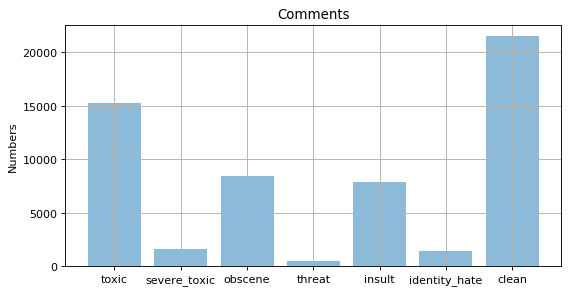

In [13]:
numbers = [data.query('toxic==1').shape[0], data.query('severe_toxic==1').shape[0],
           data.query('obscene==1').shape[0], data.query('threat==1').shape[0],
           data.query('insult==1').shape[0], data.query('identity_hate==1').shape[0],
           data.query(query_clean).shape[0]]

plt.figure(figsize=(8, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(np.arange(len(numbers)), numbers, align='center', alpha=0.5)
plt.xticks(np.arange(len(numbers)),\
           ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean'])
plt.ylabel('Numbers')
plt.title('Comments')
plt.grid()
plt.show()

## 4. Inspect the distribution of #words in the sentences

**Distribution of #words in train data**

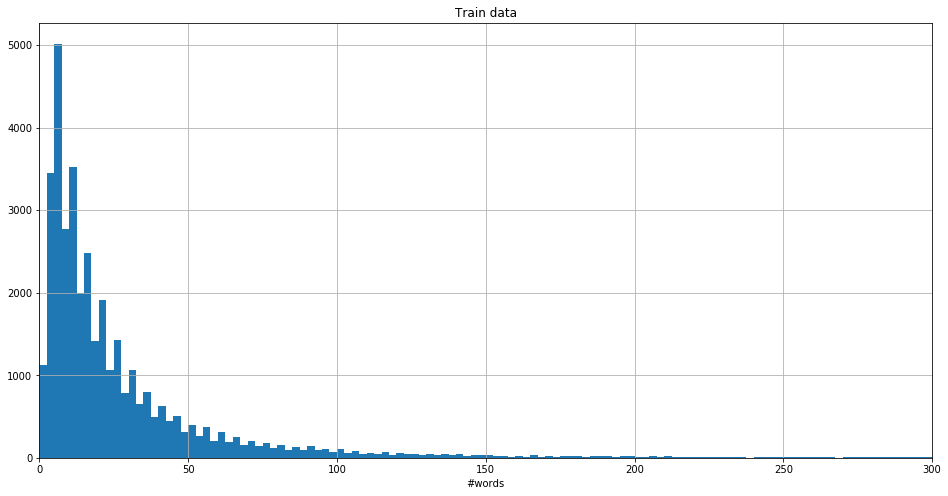

In [14]:
data.hist("length", bins=500, figsize=(16,8))
plt.title("Train data")
plt.xlabel("#words")
plt.xlim(0,300)
plt.show()

**Distribution of #words in test data**

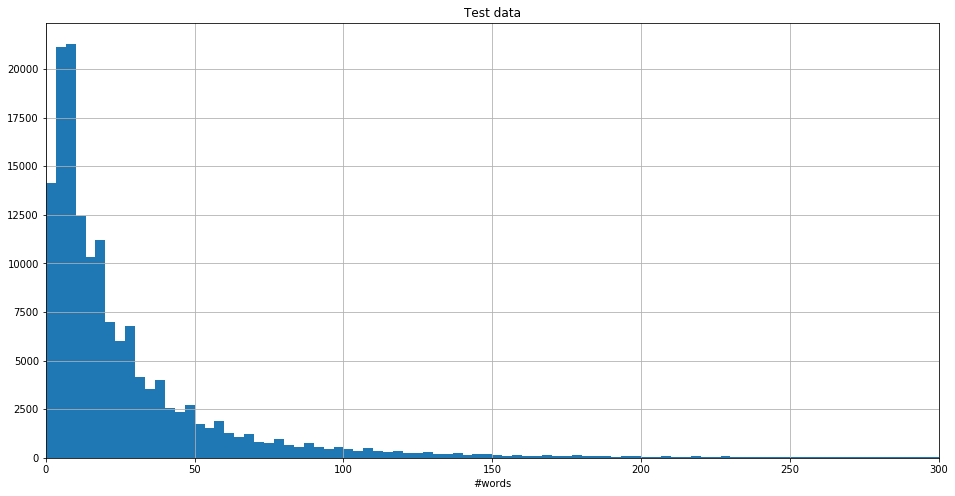

In [15]:
test_data.hist("length", bins=500, figsize=(16,8))
plt.title("Test data")
plt.xlabel("#words")
plt.xlim(0,300)
plt.show()

**Distribution of #words in all data**

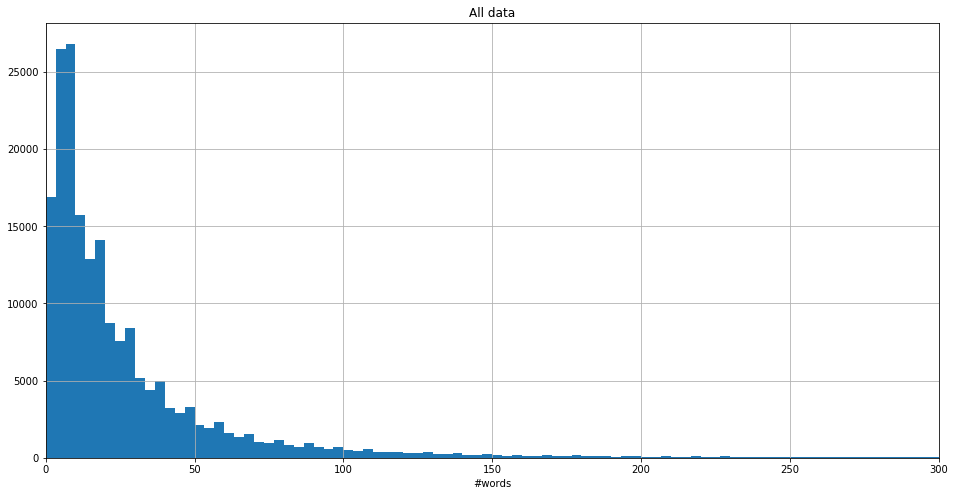

In [16]:
all_length = pd.concat([data['length'], test_data['length']])
all_length.hist(bins=500, figsize=(16,8))
plt.title("All data")
plt.xlim(0,300)
plt.xlabel("#words")
plt.show()
del(all_length)

**Split the training set into train and validation sets and save the sets if necessary**

In [17]:
train_percentage = 0.90 
train_data = data.head(int(len(data)*train_percentage))
train_data.to_csv(input_dir+"train_data.csv",header=True, index=False)
del(train_data)
valid_data = data.tail(len(data)-int(len(data)*train_percentage))
valid_size = len(valid_data)
valid_data.to_csv(input_dir+"valid_data.csv",header=True, index=False)
del(valid_data)
del(data)

## 5. Input functions

**A function to generate sequence of embeddings for the text columns**

In [18]:
def sequence_generator(comments, max_length, size):
    """
    A function to generate sequence of embeddings for the text columns
    """    
    sentences = []
    for comment in comments.tolist():
        sentences.append(str(comment).split())
        
    sequences = []
    for sentence in sentences:
        if len(sentence)>0:
            if len(sentence)<max_length:
                sequence = model[sentence]
                tail = np.zeros((max_length - len(sentence), size))
                sequence = np.concatenate((sequence, tail))
            else:
                sequence = model[sentence[:max_length]]
        else:
            sequence = np.zeros((max_length, size))        
        sequences.append(sequence)
    sequences = np.array(sequences)
    
    return sequences

**A function to generate batch of embeddings sequence, sequence length, and sentiments**

In [19]:
def generate_batch(reader, csv_path, batch_size, max_length, size, train_set=True):
    """
    A function to generate batch of embeddings sequence, sequence length, and sentiments
    """
    # read batch
    try:
        batch = reader.get_chunk()
    except:
        
        reader = pd.read_csv(csv_path, chunksize=batch_size)
        batch = reader.get_chunk()
    
    # extract columns of comments and sequence lengths
    comments_batch = batch["comment_text"].values
    seq_length_batch = batch["length"].values
    # if it is train set then extract the columns of sentiments
    if train_set:
        sentiments_batch = batch[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].values
    # generate sequence of embeddings for the comments columns
    sequences_batch = sequence_generator(comments_batch, max_length, size)
    
    if train_set:
        return sequences_batch, seq_length_batch, sentiments_batch
    else:
        return sequences_batch, seq_length_batch

## 6. Class module of multilayer lstm model

In [20]:
class multilayer_lstm_model(object):
    """
    Multilayer lstm model
    """    
    def __init__(self, n_steps, n_inputs, n_outputs, n_layers, 
                 n_neurons, dense_layers, learning_rate, device, tf_seed, np_seed):
        """
        Class constuctor which intializes the parameters, placeholders, and operations of the model
        """
        
        # parameters of lstm model
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.dense_layers = dense_layers
        self.learning_rate = learning_rate
        self.device = device
        self.tf_seed = tf_seed
        self.np_seed = np_seed    
        
        # placeholders and operations
        self.X = None
        self.Y = None
        self.Length = None
        self.keep_prob = None
        self.logits = None
        self.cost = None
        self.roc = None
        self.train_step = None
        
        # create model
        self.X, self.Y, self.Length, self.keep_prob, \
        self.logits, self.cost, self.roc, self.train_step = self.create_model()
        
        self.saver = None
        self.train_cost = None
        self.valid_cost = None
        self.valid_roc = None
        self.best_roc = None
        self.best_iteration = None
        self.best_time = None
        self.log_of_computation_time = []
        
        
    def bidirectional_lstm(self, X, n_layers, n_neurons, keep_prob, device):
        
        """
        Method to create multilayer biderectional lstm model
        """
        output = X
        # iterate through the layers of LSTM
        for layer in range(n_layers):
            with tf.variable_scope('LSTM_Layer{}'.format(layer),reuse=tf.AUTO_REUSE):
                # forward lstm cell
                cell_fw = tf.nn.rnn_cell.LSTMCell(n_neurons,
                                                  initializer=tf.variance_scaling_initializer())
                # dropout on lstm cell
                cell_fw = tf.nn.rnn_cell.DropoutWrapper(cell_fw, input_keep_prob = keep_prob)
                # mount the lstm cell on gpu
                cell_fw = tf.nn.rnn_cell.DeviceWrapper(cell_fw,device) 
                # backward lstm cell
                cell_bw = tf.nn.rnn_cell.LSTMCell(n_neurons,
                                                  initializer=tf.variance_scaling_initializer())
                # dropout on lstm cell
                cell_bw = tf.nn.rnn_cell.DropoutWrapper(cell_bw, input_keep_prob = keep_prob)
                # mount the lstm cell on gpu
                cell_bw = tf.nn.rnn_cell.DeviceWrapper(cell_bw,device) 
                # extract the outputs and states bidirectional lstm
                outputs, states = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                                  cell_bw, 
                                                                  output,
                                                                  dtype=tf.float32)
                # concat the outputs of bidirectional lstm
                output = tf.concat(outputs,2)
        
        # concat the top layer h states of bidirection lstm 
        state = tf.concat([states[0][-1], states[1][-1]], axis=-1)

        return output, state
        
        
    def create_model(self):
        """
        A method to create the multilayer lstm model
        """
        # placeholder to store the input of the model
        X = tf.placeholder(tf.float32, [None, self.n_steps, self.n_inputs])
        # placeholder to store the output of the model
        Y = tf.placeholder(tf.float32, [None, self.n_outputs])
        # placeholder to store the lengths of the sequences
        Length = tf.placeholder(tf.int32, [None])
        # keep probability for dropout
        keep_prob = tf.placeholder(tf.float32)
        
        # created bidrectional lstm and extract the top layer h state
        _, top_layer_h_state = self.bidirectional_lstm(X, self.n_layers, self.n_neurons,
                                                       keep_prob, self.device)
        
        # iterate and create the dense layer
        for n, dense_layer in enumerate(self.dense_layers):
            # first dense layer (with dropout)
            if n == 0:
                with tf.device(self.device):
                    dense = tf.layers.dense(top_layer_h_state, dense_layer,
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            activation=tf.nn.elu)
                    dense = tf.nn.dropout(dense, keep_prob=keep_prob)
             # last dense layer (without dropout)
            elif n == len(self.dense_layers)-1:
                with tf.device(self.device):
                    dense = tf.layers.dense(dense, dense_layer,
                                            kernel_initializer=tf.variance_scaling_initializer())
            # middle dense layers (with droput)
            else:
                with tf.device(self.device):
                    dense = tf.layers.dense(dense, dense_layer, 
                                            kernel_initializer=tf.variance_scaling_initializer(),
                                            activation=tf.nn.elu)
                    dense = tf.nn.dropout(dense, keep_prob=keep_prob)
                    
        # compute logits                
        with tf.device(self.device):
            logits = tf.nn.sigmoid(dense)
        # cost
        with tf.device(self.device):
            cost = tf.losses.sigmoid_cross_entropy(multi_class_labels=Y, logits=dense)
            
        roc = tf.metrics.auc(labels=Y, predictions=logits)
        # train step
        with tf.device(self.device):
            train_step = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(cost)        
        
        return X, Y, Length, keep_prob, logits, cost, roc, train_step
    
    
    def train_model(self, max_iter, batch_size, drop_prob,
                    train_data_reader,valid_data_reader,train_path, valid_path,
                    max_length, size, model_dir, model_name, generate_batch):
        """
        A method to train the multilayer lstm model
        """        
        # generate sequences, length, & sentimentas for validation set
        sequences_valid, seq_length_valid, sentiments_valid = \
        generate_batch(valid_data_reader, valid_path, valid_data_reader.chunksize,
                       self.n_steps, self.n_inputs)
        # feed dict for validation
        feed_dict_validation =  {self.X:sequences_valid,
                                 self.Y:sentiments_valid,
                                 self.Length:seq_length_valid,
                                 self.keep_prob: 1.0} 
        
        # start time
        start_time = time.time()
        # create a saver object
        saver = tf.train.Saver(max_to_keep=1)
        # lists to store the train cost, validation cost, and validation accuracy
        train_cost = []
        valid_cost = []
        valid_roc = [] 
        # variables to store the best roc and best iteration
        # and the time to reach the best roc
        best_roc = 0.0
        best_iteration = None
        best_time = None
        # path of model saver object
        model_path = model_dir+model_name
        
        # create a graph session and optimize the network under it
        with tf.Session() as sess:
        
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            
            # create an object of progress bar
            bar = progressbar.ProgressBar(maxval=max_iter, widgets=[
                '[',progressbar.Percentage(),']',
                progressbar.Bar(),
                '(',progressbar.DynamicMessage("train_cost"),')',
                '(',progressbar.DynamicMessage("valid_cost"),')',
                '(',progressbar.DynamicMessage("valid_roc"),')',
                '(',progressbar.DynamicMessage("best_valid_roc"),')',
                '(',progressbar.DynamicMessage("time_elapsed"),'mins)'
            ])
            
            # start the progress bar
            bar.start()
            # counter variable to track the number of iterations
            counter = 0
            # iterate until maximum number of iterations is reached
            while True:
                # break out of the inner for loop if maximum number of iterations is reached
                if counter>=max_iter:
                    break

            
                # generate sequences, length, & sentimentas for validation set
                sequences_batch, seq_length_batch, sentiments_batch = \
                generate_batch(train_data_reader, train_path,
                               batch_size, self.n_steps, self.n_inputs)
                # feed dict for validation
                feed_dict_batch =  {self.X:sequences_batch,
                                    self.Y:sentiments_batch,
                                    self.Length:seq_length_batch,
                                    self.keep_prob: drop_prob} 
                # execute optimization step
                sess.run(self.train_step, feed_dict=feed_dict_batch)
                # calculate temporary train cost and append it to the designated list
                temp_train_cost = self.cost.eval(session=sess, feed_dict=feed_dict_batch)
                train_cost.append(temp_train_cost)
                # calculate temporary validation cost and append it to the designated list
                temp_valid_cost = self.cost.eval(session=sess, feed_dict=feed_dict_validation)
                valid_cost.append(temp_valid_cost)
                # calculate temporary validation accuracy and append it to the designated list
                temp_valid_roc = sess.run(self.roc, feed_dict=feed_dict_validation)[1]
                valid_roc.append(temp_valid_roc)
                # compute running time from start point
                time_diff = (time.time()-start_time)/60
                # append elapsed time to the designated list
                self.log_of_computation_time.append(time_diff)
                # if valid cost is better than best recorded so far then
                # update the parameters of the best model and save the model
                if temp_valid_roc > best_roc:
                    best_time = time_diff
                    best_roc = temp_valid_roc
                    best_iteration = counter+1
                    saver.save(sess, model_path, global_step = best_iteration)

                # update the progress bar
                bar.update(counter+1, train_cost = temp_train_cost, 
                           valid_cost = temp_valid_cost,
                           valid_roc = temp_valid_roc, 
                           best_valid_roc = best_roc, 
                           time_elapsed = time_diff)
                # increment counter variable
                counter += 1
                
                # store the required variables, placeholders and operations in designated class fields
                self.saver = saver
                self.train_cost = train_cost
                self.valid_cost = valid_cost
                self.valid_roc = valid_roc
                self.best_roc = best_roc
                self.best_iteration = best_iteration
                self.best_time = best_time

            # finish the progress bar
            bar.finish()            
        
        
    def create_predictions(self, model_path, test_data_reader, test_path, 
                           test_ids, n_folds, submission_dir, submission_file):
        '''
        A function to compute predictions and submission file
        '''
        # submission path
        submission_path = submission_dir + submission_file

        with tf.Session() as sess: 
            # set random seed of tensorflow
            tf.set_random_seed(self.tf_seed)
            # restore the best model
            self.saver.restore(sess, model_path)
            # array to store the prediction
            preds = np.array([])
            # create a progress bar object
            bar = progressbar.ProgressBar(maxval=n_folds, widgets=[
                            '[',progressbar.Percentage(),']',
                            progressbar.Bar(),
                            '(',progressbar.DynamicMessage("number_of_folds_completed"),')'
                        ])
            
            # start progress bat
            bar.start()
            
            # iterate through each fold
            for i in range(n_folds):
                # generate sequences, length, & sentiments for test set
                sequences_test, seq_length_test = \
                generate_batch(test_data_reader, test_path, test_data_reader.chunksize,
                               self.n_steps, self.n_inputs, train_set=False)
                # feed dict for test
                feed_dict_test =  {self.X:sequences_test,
                                   self.Length:seq_length_test,
                                   self.keep_prob: 1.0} 
                # evaluate predictions of the fold
                fold_preds = self.logits.eval(session=sess, feed_dict = feed_dict_test)
                if i == 0:
                    preds  = fold_preds
                else:
                    preds = np.append(preds, fold_preds, axis=0)
                    
                # update the progress bar
                bar.update(i+1, number_of_folds_completed = i+1)
                
            # finish the progress bar
            bar.finish()
                    
            submission_matrix = np.append(np.transpose([test_ids]), preds, axis=1)
            columns = ["id","toxic","severe_toxic","obscene","threat","insult","identity_hate"]
            submission = pd.DataFrame(submission_matrix, columns= columns)
            submission.to_csv(submission_path, header = True, index=False)

## 7. Create graph of multilayer lstm model

**Inspect the devices of kernel**

In [21]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 706441014559579486
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15864515789
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1463530757726661124
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


**Set the device to gpu if available**

In [22]:
if len(devices)>1:
    device = devices[-1].name
else:
    device = devices[0].name

**Create graph**

In [23]:
n_layers = 2
n_neurons = 128
max_length = n_steps = 250 
n_inputs = size
n_outputs = 6
dense_layers = [36, n_outputs]
learning_rate = (1e-3)*5
tf.reset_default_graph()
sequence_model = multilayer_lstm_model(n_steps, n_inputs, n_outputs, n_layers, 
                                      n_neurons, dense_layers, learning_rate, 
                                      device, tf_rand_seed, np_rand_seed)

## 8. Train multilayer lstm model

**Train model**

In [24]:
max_iter = 220
batch_size = 200
drop_prob = 0.75
train_path = input_dir+"train_data.csv"
train_data_reader = pd.read_csv(train_path, chunksize=batch_size)
valid_path = input_dir+"valid_data.csv"
valid_data_reader = pd.read_csv(valid_path, chunksize=valid_size)
model_name = "multilayer_lstm" 
sequence_model.train_model(max_iter, batch_size, drop_prob, train_data_reader,valid_data_reader,train_path, valid_path,
                          max_length, size, model_dir, model_name, generate_batch)

[100%]||(train_cost: 0.0735)(valid_cost:   0.23)(valid_roc:  0.949)(best_valid_roc:  0.951)(time_elapsed:     19mins)


**Plot of cost vs iterations**

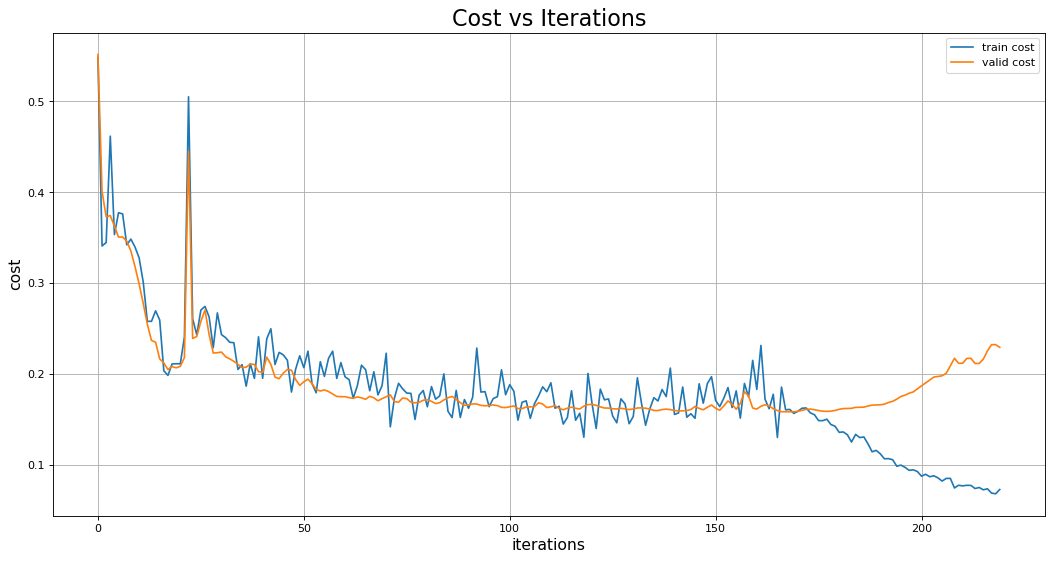

In [25]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(sequence_model.train_cost, label = 'train cost')
plt.plot(sequence_model.valid_cost, label = 'valid cost')
plt.xlabel('iterations', fontsize = 14)
plt.ylabel('cost', fontsize = 14)
plt.title("Cost vs Iterations", fontsize = 20)
plt.legend()
plt.grid()
plt.show()

**Plot of roc vs iterations**

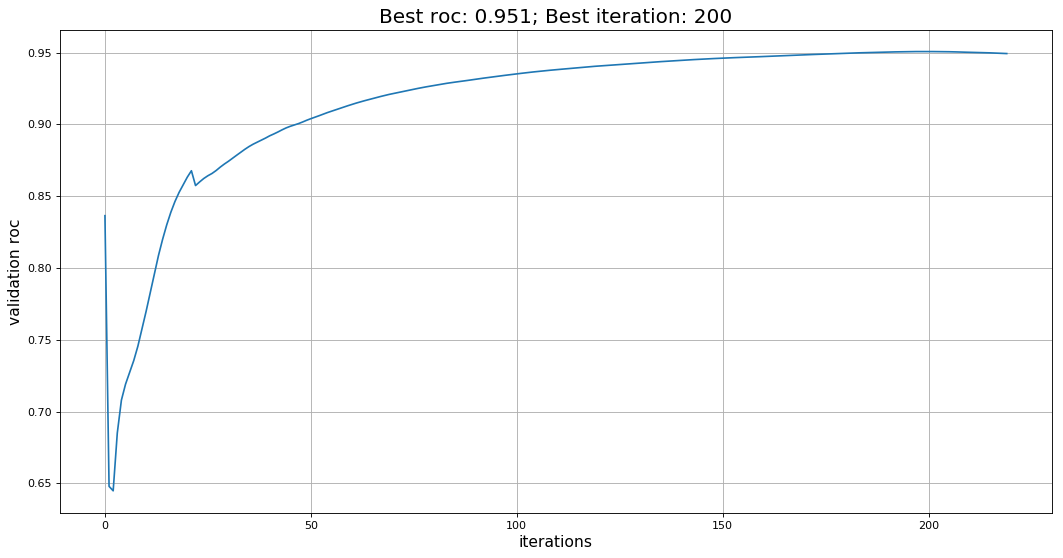

In [26]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(sequence_model.valid_roc)
plt.xlabel('iterations', fontsize = 14)
plt.ylabel('validation roc', fontsize = 14)
plt.title("Best roc: "+str(round(sequence_model.best_roc, 3))+ \
          "; Best iteration: "+str(sequence_model.best_iteration),fontsize = 18)
plt.grid()
plt.show()

## 9. Create submission csv file

In [27]:
test_size = len(test_ids)
n_folds = 100
test_batch_size = test_size//n_folds
if test_size%n_folds != 0: n_folds +=1
submission_file = "submission.csv"
test_path = input_dir+"modified_test_data.csv"
test_data_reader = pd.read_csv(test_path, chunksize=test_batch_size)
model_path = model_dir+model_name+"-"+str(sequence_model.best_iteration)
sequence_model.create_predictions(model_path, test_data_reader, test_path, 
                                  test_ids, n_folds, submission_dir, submission_file)

INFO:tensorflow:Restoring parameters from ./model_files/multilayer_lstm-200


[100%]|####################################|(number_of_folds_completed:    101)


In [28]:
pd.read_csv(submission_dir+submission_file).head(30)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.996164,0.148475,0.995982,0.035995,0.945732,0.153235
1,0000247867823ef7,0.001796,0.000007,0.000036,0.000029,0.000420,0.000313
2,00013b17ad220c46,0.001805,0.000007,0.000037,0.000029,0.000427,0.000319
3,00017563c3f7919a,0.002020,0.000008,0.000041,0.000032,0.000466,0.000337
4,00017695ad8997eb,0.002380,0.000009,0.000048,0.000037,0.000536,0.000388
5,0001ea8717f6de06,0.002129,0.000009,0.000045,0.000036,0.000499,0.000373
6,00024115d4cbde0f,0.002374,0.000009,0.000048,0.000036,0.000530,0.000381
7,000247e83dcc1211,0.891989,0.003028,0.148415,0.008172,0.246011,0.043511
8,00025358d4737918,0.785604,0.001145,0.060873,0.003188,0.124630,0.019722
9,00026d1092fe71cc,0.001804,0.000007,0.000036,0.000028,0.000419,0.000302
